**Task 1 — PneumoniaMNIST CNN Classification with Comprehensive Analysis**

In this notebook, I build an end-to-end deep learning pipeline for binary pneumonia detection using PneumoniaMNIST (MedMNIST v2). The goal is not only to train an accurate classifier, but to follow a research-grade evaluation workflow: clean preprocessing, meaningful augmentation, reproducible training, and thorough performance analysis including ROC/AUC, confusion matrix, and failure-case inspection.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Step 1 — Environment Setup (TensorFlow + Reproducibility)**

This step installs and imports the required packages. I also set random seeds to improve reproducibility and make runs more consistent across executions.

In [2]:
!pip -q install medmnist==2.* scikit-learn matplotlib

import os, random, numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)

print("TensorFlow:", tf.__version__)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 5.7 MB/s eta 0:00:00
TensorFlow: 2.19.0


**Step 2 — Load Dataset (MedMNIST v2: PneumoniaMNIST)**

PneumoniaMNIST is a lightweight benchmark dataset derived from chest X-ray images. The task is binary classification: normal vs. pneumonia. Images are 28×28 grayscale, which makes this dataset computationally friendly while still requiring careful evaluation due to the medical context.

In [3]:
import medmnist
from medmnist import PneumoniaMNIST

from tensorflow.keras.utils import to_categorical

# Load splits
train_data = PneumoniaMNIST(split="train", download=True)
val_data   = PneumoniaMNIST(split="val", download=True)
test_data  = PneumoniaMNIST(split="test", download=True)

print("Train size:", len(train_data))
print("Val size:", len(val_data))
print("Test size:", len(test_data))

# Extract numpy arrays
X_train, y_train = train_data.imgs, train_data.labels
X_val,   y_val   = val_data.imgs,   val_data.labels
X_test,  y_test  = test_data.imgs,  test_data.labels

print("Raw X_train shape:", X_train.shape, "dtype:", X_train.dtype)
print("Raw y_train shape:", y_train.shape, "unique:", np.unique(y_train))


100%|██████████| 4.17M/4.17M [00:01<00:00, 3.74MB/s]


Train size: 4708
Val size: 524
Test size: 624
Raw X_train shape: (4708, 28, 28) dtype: uint8
Raw y_train shape: (4708, 1) unique: [0 1]


**Step 3 — Quick Data Sanity Check (Samples + Class Balance)**

Before modeling, it is essential to verify that the dataset loads correctly, understand the label distribution, and visually inspect sample images. In medical imaging, label imbalance and ambiguous samples can strongly influence model behavior, so this step also helps anticipate likely failure modes.

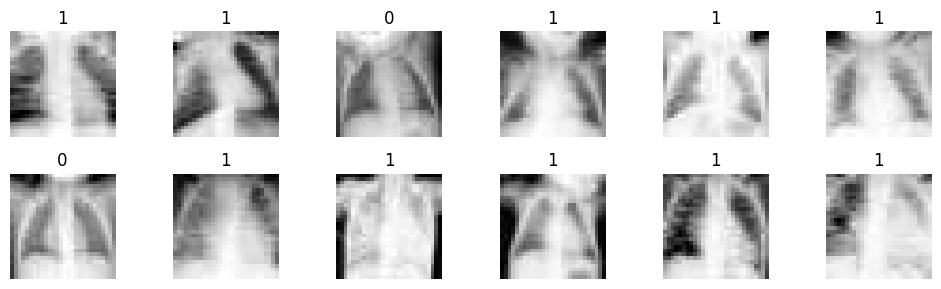

Train class distribution: {0: 1214, 1: 3494}
Val class distribution: {0: 135, 1: 389}
Test class distribution: {0: 234, 1: 390}


In [4]:
def show_samples(X, y, n=12):
    plt.figure(figsize=(10, 3))
    idxs = np.random.choice(len(X), n, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(2, n//2, i+1)
        plt.imshow(X[idx].squeeze(), cmap="gray")
        plt.title(int(y[idx][0]))
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_samples(X_train, y_train, n=12)

def class_distribution(y):
    vals, counts = np.unique(y, return_counts=True)
    return dict(zip(vals.flatten().tolist(), counts.tolist()))

print("Train class distribution:", class_distribution(y_train))
print("Val class distribution:", class_distribution(y_val))
print("Test class distribution:", class_distribution(y_test))


**Step 4 — Preprocessing (Normalization + Tensor Shapes)**

Neural networks train more reliably when inputs are normalized. Here, images are scaled to [0, 1] and reshaped to include a channel dimension (28, 28, 1) required by TensorFlow CNN layers. This keeps preprocessing minimal and medically appropriate.

In [5]:
# Convert to float32 and normalize to [0,1]
X_train = X_train.astype("float32") / 255.0
X_val   = X_val.astype("float32") / 255.0
X_test  = X_test.astype("float32") / 255.0

# Ensure channel dimension (N,28,28,1)
if X_train.ndim == 3:
    X_train = np.expand_dims(X_train, -1)
    X_val   = np.expand_dims(X_val, -1)
    X_test  = np.expand_dims(X_test, -1)

print("Processed X_train shape:", X_train.shape)

# Labels as int
y_train_int = y_train.astype(int).squeeze()
y_val_int   = y_val.astype(int).squeeze()
y_test_int  = y_test.astype(int).squeeze()

print("y_train_int shape:", y_train_int.shape, "unique:", np.unique(y_train_int))


Processed X_train shape: (4708, 28, 28, 1)
y_train_int shape: (4708,) unique: [0 1]


**Step 5 — Data Augmentation (Meaningful for Chest X-rays)**

Data augmentation can improve generalization, but medical images require caution: unrealistic transformations may harm clinical validity. Here, I apply small rotations and translations, which simulate mild positioning variation while preserving medically relevant structures.

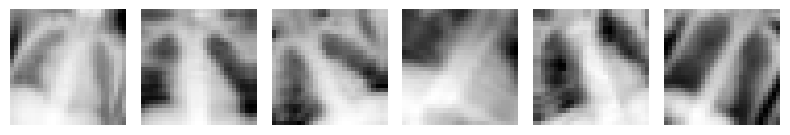

In [6]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.08, seed=SEED),       # ~±14 degrees
    tf.keras.layers.RandomTranslation(0.05, 0.05, seed=SEED),
])

# Visualize augmentation effect
plt.figure(figsize=(8, 2))
for i in range(6):
    ax = plt.subplot(1, 6, i+1)
    img = X_train[i]
    aug = data_augmentation(tf.expand_dims(img, 0), training=True)
    plt.imshow(aug[0].numpy().squeeze(), cmap="gray")
    plt.axis("off")
plt.tight_layout()
plt.show()


**Step 6 — Efficient Data Pipeline with tf.data**

To train efficiently and cleanly, I construct tf.data pipelines for training/validation/testing. The training pipeline includes augmentation, shuffling, batching, and prefetching. Validation and test pipelines skip augmentation to ensure fair evaluation.

In [7]:
BATCH_SIZE = 128

def make_dataset(X, y, training=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if training:
        ds = ds.shuffle(2000, seed=SEED, reshuffle_each_iteration=True)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(X_train, y_train_int, training=True)
val_ds   = make_dataset(X_val,   y_val_int,   training=False)
test_ds  = make_dataset(X_test,  y_test_int,  training=False)

# Augmentation applied in-model or in-map; we'll apply in-model for simplicity & reproducibility.


**Step 7 — Model Design (Compact CNN Baseline)**

Given the small 28×28 input size, I start with a compact CNN designed to learn local texture patterns. The architecture uses stacked convolution blocks with batch normalization and dropout for regularization. This baseline provides a transparent, reproducible reference before exploring heavier models.

In [8]:
from tensorflow.keras import layers, models

def build_cnn():
    inputs = layers.Input(shape=(28, 28, 1))
    x = data_augmentation(inputs)  # augmentation only during training

    x = layers.Conv2D(32, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D()(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D()(x)

    x = layers.Conv2D(128, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.2)(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)
    return models.Model(inputs, outputs, name="cnn_baseline")

model = build_cnn()
model.summary()


Model: "cnn_baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,889 (398.00 KB)

 Trainable params: 101,441 (396.25 KB)

 Non-trainable params: 448 (1.75 KB)

**Step 8 — Training Setup (Loss, Optimizer, Scheduling)**

For binary classification, I use binary cross-entropy. I optimize using Adam and include a learning-rate reduction callback to stabilize training. Early stopping is applied to prevent overfitting and keep the best-performing model (based on validation loss).

In [9]:
# Loss with label smoothing (better calibration, often fewer false positives)
loss_fn = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss=loss_fn,
    metrics=[tf.keras.metrics.BinaryAccuracy(name="acc"),
             tf.keras.metrics.AUC(name="auc")]
)

# Class weights
classes = np.array([0, 1])
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train_int)
class_weight = {0: cw[0], 1: cw[1]}
print("class_weight:", class_weight)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "saved_models/best_task1.keras",
        monitor="val_auc",
        mode="max",
        save_best_only=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_auc",
        mode="max",
        factor=0.5,
        patience=4,
        min_lr=1e-6,
        verbose=1
    )
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=90,   # fixed length (try 60 first)
    callbacks=callbacks,
    class_weight=class_weight,
    verbose=1
)

# load best checkpoint explicitly
best_model = tf.keras.models.load_model("saved_models/best_task1.keras")


class_weight: {0: np.float64(1.9390444810543657), 1: np.float64(0.6737263880938752)}
Epoch 1/90
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.7730 - auc: 0.8179 - loss: 0.5480
Epoch 1: val_auc improved from -inf to 0.67444, saving model to saved_models/best_task1.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - acc: 0.7741 - auc: 0.8201 - loss: 0.5455 - val_acc: 0.7424 - val_auc: 0.6744 - val_loss: 0.5819 - learning_rate: 3.0000e-04
Epoch 2/90
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.8882 - auc: 0.9557 - loss: 0.3393
Epoch 2: val_auc improved from 0.67444 to 0.68376, saving model to saved_models/best_task1.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - acc: 0.8886 - auc: 0.9560 - loss: 0.3383 - val_acc: 0.7424 - val_auc: 0.6838 - val_loss: 0.9270 - learning_rate: 3.0000e-04
Epoch 3/90
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.9075 - auc: 0.9707 - loss: 0.2973
Epoch 3: val_auc did not improve from 0.68376
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - acc: 0.9075 - auc: 0.

**Step 9 — Learning Curves (Diagnosing Overfitting/Underfitting)**

Learning curves provide insight into training dynamics. By plotting loss and AUC over epochs, we can detect instability, overfitting, or underfitting—important for credible medical ML evaluation.

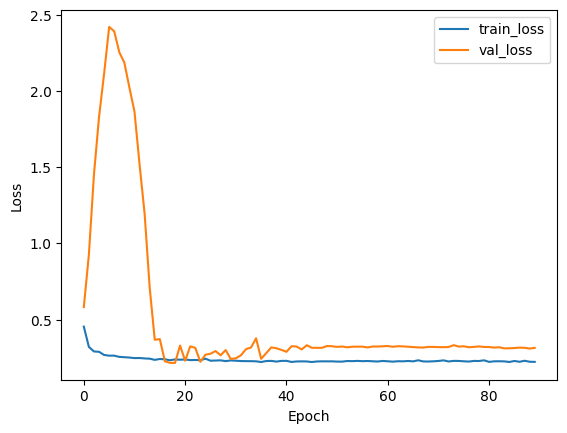

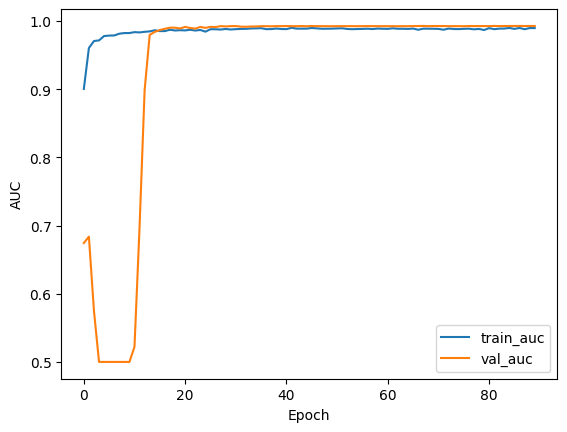

In [10]:
def plot_history(history):
    hist = history.history
    plt.figure()
    plt.plot(hist["loss"], label="train_loss")
    plt.plot(hist["val_loss"], label="val_loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()

    plt.figure()
    plt.plot(hist["auc"], label="train_auc")
    plt.plot(hist["val_auc"], label="val_auc")
    plt.xlabel("Epoch"); plt.ylabel("AUC"); plt.legend(); plt.show()

plot_history(history)


**Step 10 — Final Evaluation (Test Set Metrics)**

In medical imaging, accuracy alone can be misleading. Therefore, I report precision, recall, F1-score, and AUC, along with a confusion matrix and ROC curve. Special attention is given to false negatives, which correspond to missed pneumonia cases.

In [11]:
# Predict probabilities
y_prob = model.predict(test_ds).squeeze()
y_pred = (y_prob >= 0.5).astype(int)

acc  = accuracy_score(y_test_int, y_pred)
prec = precision_score(y_test_int, y_pred, zero_division=0)
rec  = recall_score(y_test_int, y_pred, zero_division=0)
f1   = f1_score(y_test_int, y_pred, zero_division=0)
auc  = roc_auc_score(y_test_int, y_prob)

print("Test Accuracy :", acc)
print("Test Precision:", prec)
print("Test Recall   :", rec)
print("Test F1       :", f1)
print("Test AUC      :", auc)

print("\nClassification report:\n", classification_report(y_test_int, y_pred, digits=4))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Test Accuracy : 0.8942307692307693
Test Precision: 0.9196891191709845
Test Recall   : 0.9102564102564102
Test F1       : 0.9149484536082474
Test AUC      : 0.9543392504930965

Classification report:
               precision    recall  f1-score   support

           0     0.8529    0.8675    0.8602       234
           1     0.9197    0.9103    0.9149       390

    accuracy                         0.8942       624
   macro avg     0.8863    0.8889    0.8876       624
weighted avg     0.8947    0.8942    0.8944       624



In [18]:
# ==============================
# 🔹 SAVE PREDICTIONS FOR TASK 2
# ==============================

import pandas as pd
import numpy as np
import os

# Create dataframe
df_pred = pd.DataFrame({
    "index": np.arange(len(y_test_int)),   # important: maps directly to X_test_raw[idx]
    "y_true": y_test_int.astype(int),
    "y_prob": y_prob.astype(float),
    "y_pred": y_pred.astype(int)
})

# Save CSV locally
csv_path = "task1_test_predictions.csv"
df_pred.to_csv(csv_path, index=False)
print("\nSaved predictions to:", csv_path)

# Save misclassified indices
mis_idx = df_pred[df_pred["y_true"] != df_pred["y_pred"]]["index"].tolist()

with open("task1_misclassified_indices.txt", "w") as f:
    for idx in mis_idx:
        f.write(str(idx) + "\n")

print("Saved misclassified indices file.")
print("Number of misclassified samples:", len(mis_idx))


# ==============================
# 🔹 OPTIONAL: SAVE TO GOOGLE DRIVE
# ==============================

try:
    from google.colab import drive
    drive.mount("/content/drive")

    DRIVE_DIR = "/content/drive/MyDrive/Alfaisal_Postdoc_Challenge"
    os.makedirs(DRIVE_DIR, exist_ok=True)

    df_pred.to_csv(os.path.join(DRIVE_DIR, "task1_test_predictions.csv"), index=False)

    with open(os.path.join(DRIVE_DIR, "task1_misclassified_indices.txt"), "w") as f:
        for idx in mis_idx:
            f.write(str(idx) + "\n")

    print("Files copied to Google Drive:", DRIVE_DIR)

except:
    print("Google Drive not mounted (skipping Drive save).")



Saved predictions to: task1_test_predictions.csv
Saved misclassified indices file.
Number of misclassified samples: 66
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Files copied to Google Drive: /content/drive/MyDrive/Alfaisal_Postdoc_Challenge


**Step 11 — Confusion Matrix (Error Types)**

The confusion matrix breaks errors into false positives and false negatives. This is crucial for understanding clinical risk: a false negative (missed pneumonia) may be more harmful than a false positive (unnecessary follow-up).

Confusion Matrix:
 [[203  31]
 [ 35 355]]


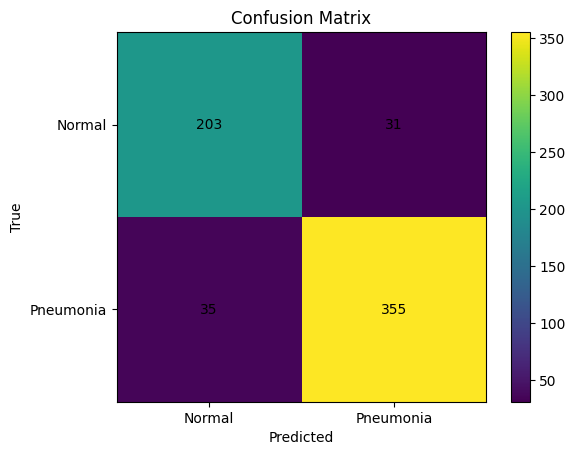

TN, FP, FN, TP = 203 31 35 355
Sensitivity (Pneumonia Recall): 0.9103
Specificity (Normal Recall): 0.8675


In [12]:
cm = confusion_matrix(y_test_int, y_pred)
print("Confusion Matrix:\n", cm)

plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks([0,1], ["Normal", "Pneumonia"])
plt.yticks([0,1], ["Normal", "Pneumonia"])

for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")

plt.colorbar()
plt.show()




tn, fp, fn, tp = cm.ravel()

sensitivity = tp / (tp + fn)   # pneumonia recall
specificity = tn / (tn + fp)   # normal recall

print("TN, FP, FN, TP =", tn, fp, fn, tp)
print("Sensitivity (Pneumonia Recall):", round(sensitivity, 4))
print("Specificity (Normal Recall):", round(specificity, 4))



**Step 12 — ROC Curve (Threshold-independent Performance)**

The ROC curve shows the trade-off between true positive rate and false positive rate across thresholds. AUC summarizes overall separability of the two classes and is widely used for diagnostic models.

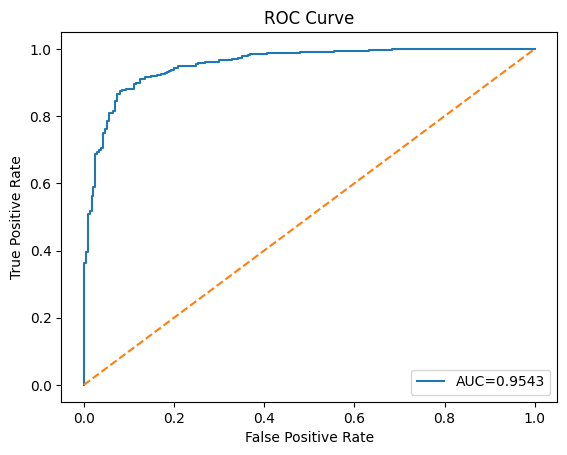

In [13]:
fpr, tpr, thresholds = roc_curve(y_test_int, y_prob)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC={auc:.4f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


**Step 13 — Qualitative Inspection (Sample Predictions)**

Beyond metrics, visual inspection of predictions helps verify that results are plausible. I display a mix of correct and incorrect cases, along with predicted probabilities, to understand where the model succeeds and where it struggles.

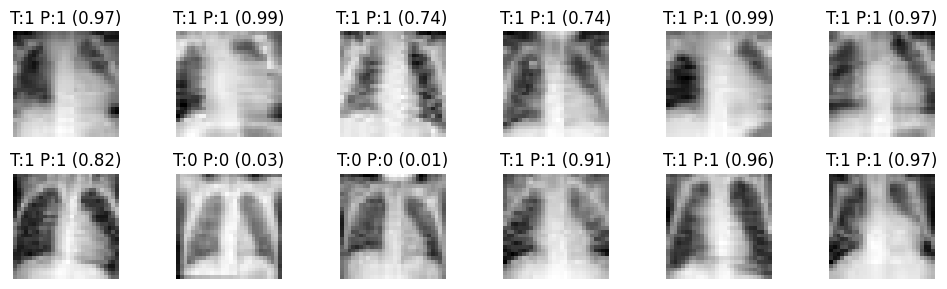

In [14]:
def show_predictions(X, y_true, y_prob, n=12, only_errors=False):
    y_pred = (y_prob >= 0.5).astype(int)
    idxs = np.arange(len(X))
    if only_errors:
        idxs = idxs[y_pred != y_true]
        if len(idxs) == 0:
            print("No errors found.")
            return
    chosen = np.random.choice(idxs, min(n, len(idxs)), replace=False)

    plt.figure(figsize=(10, 3))
    for i, idx in enumerate(chosen):
        plt.subplot(2, max(1, len(chosen)//2), i+1)
        plt.imshow(X[idx].squeeze(), cmap="gray")
        plt.title(f"T:{y_true[idx]} P:{y_pred[idx]} ({y_prob[idx]:.2f})")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Need raw arrays for indexing (not batched)
show_predictions(X_test, y_test_int, y_prob, n=12, only_errors=False)


**Step 14 — Failure Case Analysis (Misclassifications)**

To understand limitations, I inspect misclassified images. Common causes may include low resolution (28×28), subtle radiographic patterns, and ambiguous cases. This analysis helps explain why the model fails and suggests improvements (e.g., higher-resolution data, attention mechanisms, or better preprocessing).

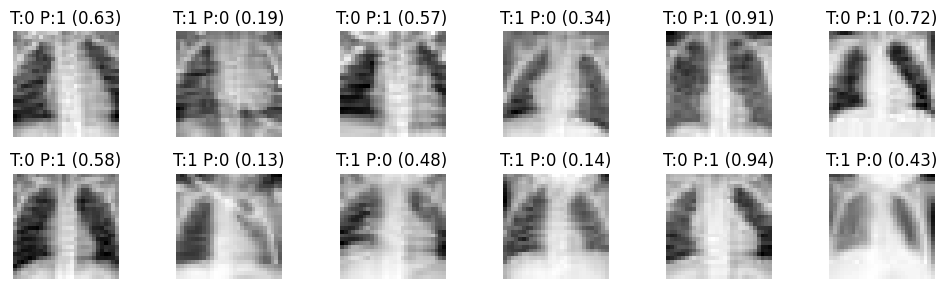

TN=203, FP=31, FN=35, TP=355


In [15]:
show_predictions(X_test, y_test_int, y_prob, n=12, only_errors=True)

# Print counts of FP/FN
y_pred = (y_prob >= 0.5).astype(int)
fp = np.sum((y_test_int == 0) & (y_pred == 1))
fn = np.sum((y_test_int == 1) & (y_pred == 0))
tp = np.sum((y_test_int == 1) & (y_pred == 1))
tn = np.sum((y_test_int == 0) & (y_pred == 0))

print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")


**Step 15 — Saving the Model for Reproducibility**

To ensure reproducibility and allow reviewers to run evaluation without retraining, I save the trained model weights. This also supports downstream tasks (e.g., using CNN misclassifications during Task 2).

In [19]:
os.makedirs("/content/drive/MyDrive/Alfaisal_Postdoc_Challenge/saved_models", exist_ok=True)
model.save("/content/drive/MyDrive/Alfaisal_Postdoc_Challenge/saved_models/task1_cnn_baseline.keras")
print("Saved to saved_models/task1_cnn_baseline.keras")


Saved to saved_models/task1_cnn_baseline.keras
